In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.metrics import geometric_mean_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import f_classif
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, confusion_matrix, auc, matthews_corrcoef, fbeta_score
from sklearn.inspection import permutation_importance

In [15]:
# This is to ensure all plot variables are available and default (in case they were modified in code)
from importlib import reload
plt=reload(plt)

In [16]:
filename = 'baseline_clean.csv'
df = pd.read_csv(filename, dtype=str)
df_raw = df

In [17]:
df = df[df['is_gambler'] == '1']

In [18]:
keep_cols = [
    'Q13_1',
    'Q13_2',
    'Q13_3',
    'Q13_4',
    'Q13_5',
    'Q13_6',
    'Q13_7',
    'Q13_8',
    'Q13_9',
    'Q13_11',
    'Q14',
    'pgsi_binary',
    # 'Q16i_recoded',
    'Q18',
    'lotto_count',
    'Q20',
    'delay_count',
]

In [19]:
df = df[keep_cols]

In [20]:
numeric_cols = ['Q18', 'Q20', 'lotto_count', 'delay_count', 'Q14']
binary_cols = ['Q13_1', 'Q13_2', 'Q13_3', 'Q13_4', 'Q13_5', 'Q13_6', 'Q13_7', 'Q13_8', 'Q13_9', 'Q13_11', 'pgsi_binary']
exclude_cols = numeric_cols + binary_cols
dummy_cols = [i for i in df.columns if i not in exclude_cols]

In [21]:
scaler = MinMaxScaler()
for c in numeric_cols:
    df[c] = scaler.fit_transform(df[[c]])

In [22]:
for c in binary_cols:
    df[c] = df[c].astype('int')

In [23]:
df = pd.get_dummies(df, columns=dummy_cols)

In [24]:
y = df['pgsi_binary'].astype('str')
X = df.drop(['pgsi_binary'], axis=1)

In [25]:
X.shape

(1194, 15)

In [26]:
X.head()

,Q13_1,Q13_2,Q13_3,Q13_4,Q13_5,Q13_6,Q13_7,Q13_8,Q13_9,Q13_11,Q14,Q18,lotto_count,Q20,delay_count
2,1,0,0,0,0,0,0,0,0,0,0.005135,0.9,0.2,0.8,0.8
3,0,1,0,1,0,0,0,0,0,0,0.014121,0.6,0.4,0.8,0.4
4,0,0,0,1,1,0,0,0,0,0,0.014121,0.9,0.4,0.8,0.6
5,0,0,0,1,0,0,0,0,0,0,0.029525,0.7,0.4,0.8,0.4
6,0,0,0,1,0,0,1,0,0,0,0.065469,0.8,0.2,0.6,0.0


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42, sampling_strategy='auto')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [28]:
X_train.shape

(955, 15)

In [29]:
X_train_resampled.shape

(1576, 15)

In [30]:
class_num = len(y_train.unique())
class_num

2

In [31]:
X_train = X_train_resampled
y_train = y_train_resampled

In [32]:
pl = '1'

In [33]:
X_train.shape

(1576, 15)

In [34]:
X_test.shape

(239, 15)

In [76]:
param_grid = {
    'Cs': [1, 10, 20],
    'solver': ['newton-cg', 'newton-cholesky']
}
lr = LogisticRegressionCV(random_state=42)
grid_search = GridSearchCV(lr, param_grid, cv=10, scoring='f1_macro', n_jobs=-1)  # StratifiedKFold used by default
grid_search.fit(X_train, y_train)
best_lr = grid_search.best_estimator_
y_pred = best_lr.predict(X_test)
y_prob = best_lr.predict_proba(X_test)
best_lr.fit(X_test, y_test)
print(grid_search.best_params_)

C:\Users\u4587\anaconda3\envs\COMP8410\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\u4587\anaconda3\envs\COMP8410\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\u4587\anaconda3\envs\COMP8410\lib\site-packages\sklearn\linear_model\_logistic.py", line 1762, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\u4587\anaconda3\envs\COMP8410\lib\site-packages\sklearn\linear_model\_logistic.p

{'Cs': 10, 'penalty': 'l2', 'solver': 'newton-cg'}


In [36]:
accuracy = accuracy_score(y_test, y_pred)
gmean_comb = geometric_mean_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, pos_label=pl)
f1_comb = f1_score(y_test, y_pred, average='macro')
f2_comb = fbeta_score(y_test, y_pred, beta=2, average='macro')
f05_comb = fbeta_score(y_test, y_pred, beta=0.5, average='macro')
roc_auc = roc_auc_score(y_test, y_pred.astype('float'))
precision = precision_score(y_test, y_pred, pos_label=pl)
precision_comb = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, pos_label=pl)
recall_comb = recall_score(y_test, y_pred, average='macro')
phi = matthews_corrcoef(y_test, y_pred)
print('Accuracy:', round(accuracy, 2))
print('G Mean Comb:', round(gmean_comb, 2))
print('F1:', round(f1, 2))
print('F0.5 Comb:', round(f05_comb, 2))
print('F1 Comb:', round(f1_comb, 2))
print('F2 Comb:', round(f2_comb, 2))
print('ROC AUC:', round(roc_auc, 2))
print('Precision:', round(precision, 2))
print('Precision Comb:', round(precision_comb, 2))
print('Recall:', round(recall, 2))
print('Recall Comb:', round(recall_comb, 2))
print('Phi:', round(phi, 2))

Accuracy: 0.69
G Mean Comb: 0.65
F1: 0.46
F0.5 Comb: 0.62
F1 Comb: 0.62
F2 Comb: 0.64
ROC AUC: 0.65
Precision: 0.38
Precision Comb: 0.62
Recall: 0.57
Recall Comb: 0.65
Phi: 0.27


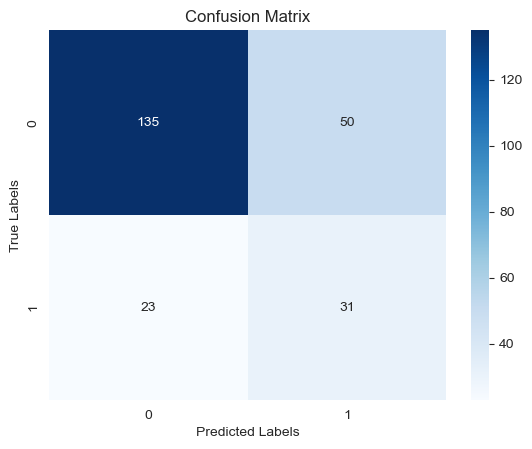

In [37]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

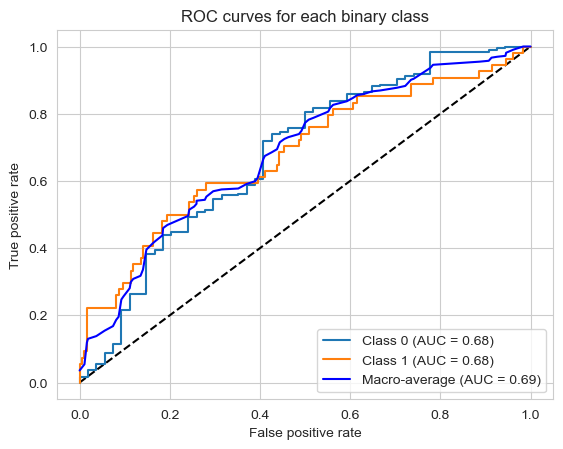

In [38]:
class_num = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(class_num):
    fpr[i], tpr[i], _ = roc_curve(y_test == str(i), y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(class_num)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(class_num):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= class_num
macro_auc = auc(all_fpr, mean_tpr)

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
for i in range(class_num):
    plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))
plt.plot(all_fpr, mean_tpr, 'b-', label='Macro-average (AUC = {:.2f})'.format(macro_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves for each binary class')
plt.legend(loc='lower right')
plt.show()

In [39]:
coefficients = best_lr.coef_[0]
feature_importance = pd.DataFrame(
    {"feature": X_train.columns, "importance": coefficients}, index=X_train.columns
)

feature_importance_sorted = feature_importance.sort_values(by="importance", ascending=False)
feature_importance_sorted = feature_importance_sorted.head(20)

In [40]:
display(feature_importance_sorted)

,feature,importance
Q14,Q14,6.213844
Q13_9,Q13_9,3.939045
Q13_8,Q13_8,1.080859
Q20,Q20,1.051693
Q13_1,Q13_1,0.863512
Q13_6,Q13_6,0.676645
Q13_3,Q13_3,0.512205
Q13_2,Q13_2,0.493489
Q18,Q18,0.393673
Q13_7,Q13_7,0.163384


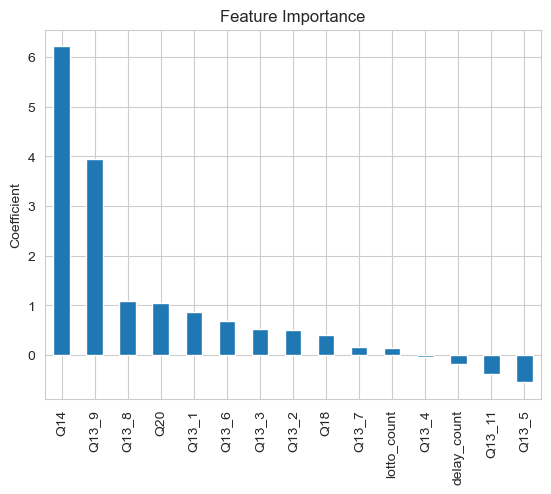

In [41]:
feature_importance_sorted.plot.bar()
plt.xticks(rotation=90)
plt.ylabel("Coefficient")
plt.title("Feature Importance")
plt.legend('',frameon=False)
plt.show()

In [42]:
coefficients = np.exp(best_lr.coef_[0])
feature_importance = pd.DataFrame(
    {"feature": X_train.columns, "importance": coefficients}, index=X_train.columns
)

feature_importance_sorted = feature_importance.sort_values(by="importance", ascending=False)
feature_importance_sorted = feature_importance_sorted.head(20)

In [43]:
display(feature_importance_sorted)

,feature,importance
Q14,Q14,499.618147
Q13_9,Q13_9,51.369542
Q13_8,Q13_8,2.947211
Q20,Q20,2.862492
Q13_1,Q13_1,2.371474
Q13_6,Q13_6,1.967267
Q13_3,Q13_3,1.668967
Q13_2,Q13_2,1.638021
Q18,Q18,1.482415
Q13_7,Q13_7,1.177489


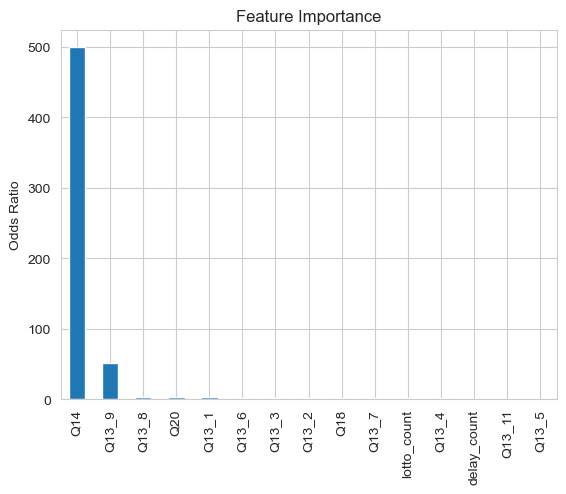

In [44]:
feature_importance_sorted.plot.bar()
plt.xticks(rotation=90)
plt.ylabel("Odds Ratio")
plt.title("Feature Importance")
plt.legend('',frameon=False)
plt.show()

In [45]:
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2]
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=10, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)
best_rf.fit(X_test, y_test)
print(grid_search.best_params_)

{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [46]:
accuracy = accuracy_score(y_test, y_pred)
gmean_comb = geometric_mean_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, pos_label=pl)
f1_comb = f1_score(y_test, y_pred, average='macro')
f2_comb = fbeta_score(y_test, y_pred, beta=2, average='macro')
f05_comb = fbeta_score(y_test, y_pred, beta=0.5, average='macro')
roc_auc = roc_auc_score(y_test, y_pred.astype('float'))
precision = precision_score(y_test, y_pred, pos_label=pl)
precision_comb = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, pos_label=pl)
recall_comb = recall_score(y_test, y_pred, average='macro')
phi = matthews_corrcoef(y_test, y_pred)
print('Accuracy:', round(accuracy, 2))
print('G Mean Comb:', round(gmean_comb, 2))
print('F1:', round(f1, 2))
print('F0.5 Comb:', round(f05_comb, 2))
print('F1 Comb:', round(f1_comb, 2))
print('F2 Comb:', round(f2_comb, 2))
print('ROC AUC:', round(roc_auc, 2))
print('Precision:', round(precision, 2))
print('Precision Comb:', round(precision_comb, 2))
print('Recall:', round(recall, 2))
print('Recall Comb:', round(recall_comb, 2))
print('Phi:', round(phi, 2))

Accuracy: 0.73
G Mean Comb: 0.55
F1: 0.27
F0.5 Comb: 0.56
F1 Comb: 0.55
F2 Comb: 0.55
ROC AUC: 0.55
Precision: 0.35
Precision Comb: 0.57
Recall: 0.22
Recall Comb: 0.55
Phi: 0.12


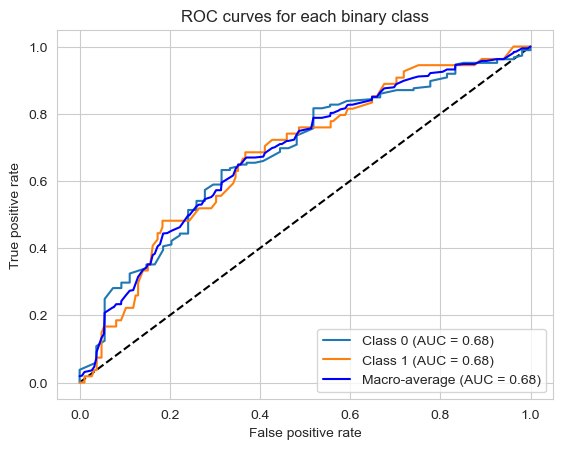

In [47]:
class_num = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(class_num):
    fpr[i], tpr[i], _ = roc_curve(y_test == str(i), y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(class_num)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(class_num):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= class_num
macro_auc = auc(all_fpr, mean_tpr)

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
for i in range(class_num):
    plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))
plt.plot(all_fpr, mean_tpr, 'b-', label='Macro-average (AUC = {:.2f})'.format(macro_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves for each binary class')
plt.legend(loc='lower right')
plt.show()

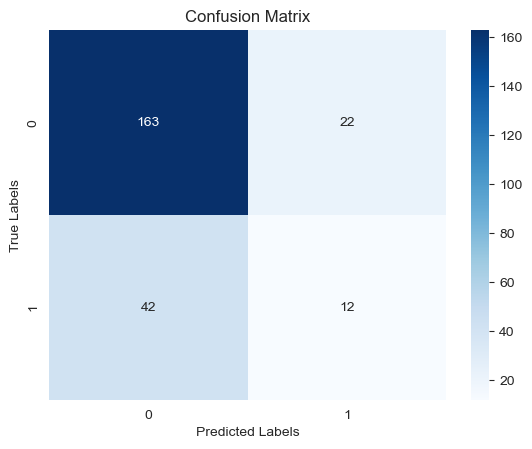

In [48]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

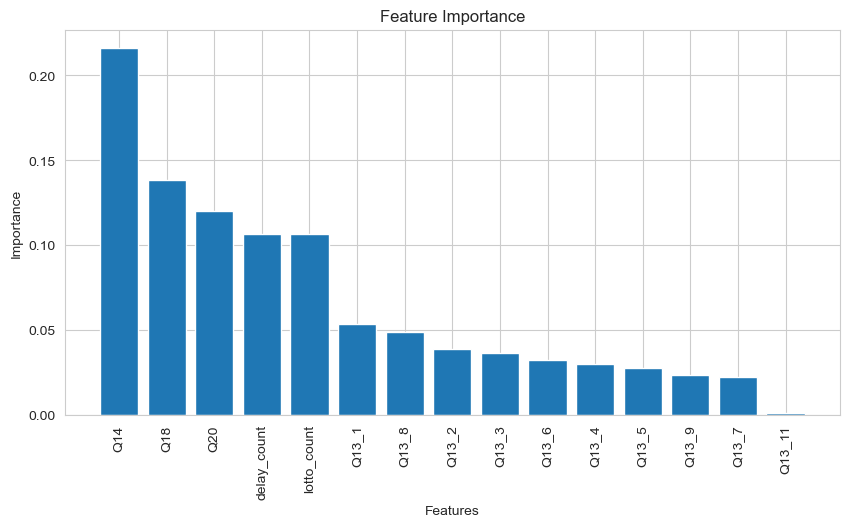

In [49]:
importances = best_rf.feature_importances_
feature_names = X_train.columns
sorted_idx = np.argsort(importances)[::-1][:20]
sorted_importances = importances[sorted_idx]
sorted_feature_names = [feature_names[i] for i in sorted_idx]
plt.figure(figsize=(10, 5))
plt.bar(sorted_feature_names, sorted_importances)
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

In [50]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

In [51]:
# Average the trees in the forest
tree_importances = np.zeros((X_train.shape[1],), dtype=np.float64)
for tree in best_rf.estimators_:
    tree_importances += tree.feature_importances_
tree_importances /= len(best_rf.estimators_)

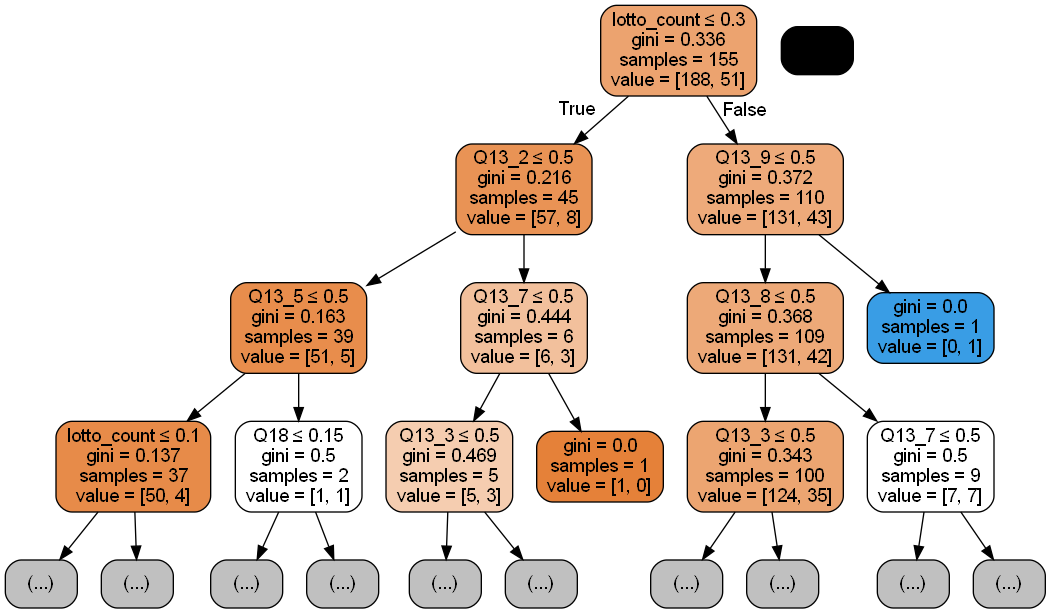

In [52]:
dot_data = export_graphviz(best_rf.estimators_[0], out_file=None,
                           feature_names=X_train.columns,
                           filled=True, rounded=True,
                           special_characters=True,
                           max_depth=3)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [53]:
param_grid = {
    'C': [0.1, 1, 50, 100, 1000, 10000],
    'kernel': ['linear', 'rbf']
}

all_params = ParameterGrid(param_grid)
# Filter the param grid so that only C values correspond with the kernel type: rbf will have higher values than linear
new_grid = []
for i in all_params:
    if (i['kernel'] == 'linear' and i['C'] <= 20) or (i['kernel'] == 'rbf' and i['C'] > 20):
        _temp = {}
        for k in i.keys():
            _temp[k] = [i[k]]
        new_grid.append(_temp)

svc = SVC(random_state=42, probability=True)
grid_search = GridSearchCV(svc, param_grid=new_grid, cv=10, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_svc = grid_search.best_estimator_
y_pred = best_svc.predict(X_test)
y_prob = best_svc.predict_proba(X_test)
best_svc.fit(X_test, y_test)
best_params = grid_search.best_params_
print(grid_search.best_params_)

{'C': 10000, 'kernel': 'rbf'}


In [54]:
accuracy = accuracy_score(y_test, y_pred)
gmean_comb = geometric_mean_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, pos_label=pl)
f1_comb = f1_score(y_test, y_pred, average='macro')
f2_comb = fbeta_score(y_test, y_pred, beta=2, average='macro')
f05_comb = fbeta_score(y_test, y_pred, beta=0.5, average='macro')
roc_auc = roc_auc_score(y_test, y_pred.astype('float'))
precision = precision_score(y_test, y_pred, pos_label=pl)
precision_comb = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, pos_label=pl)
recall_comb = recall_score(y_test, y_pred, average='macro')
phi = matthews_corrcoef(y_test, y_pred)
print('Accuracy:', round(accuracy, 2))
print('G Mean Comb:', round(gmean_comb, 2))
print('F1:', round(f1, 2))
print('F0.5 Comb:', round(f05_comb, 2))
print('F1 Comb:', round(f1_comb, 2))
print('F2 Comb:', round(f2_comb, 2))
print('ROC AUC:', round(roc_auc, 2))
print('Precision:', round(precision, 2))
print('Precision Comb:', round(precision_comb, 2))
print('Recall:', round(recall, 2))
print('Recall Comb:', round(recall_comb, 2))
print('Phi:', round(phi, 2))

Accuracy: 0.68
G Mean Comb: 0.56
F1: 0.32
F0.5 Comb: 0.55
F1 Comb: 0.55
F2 Comb: 0.55
ROC AUC: 0.56
Precision: 0.31
Precision Comb: 0.55
Recall: 0.33
Recall Comb: 0.56
Phi: 0.11


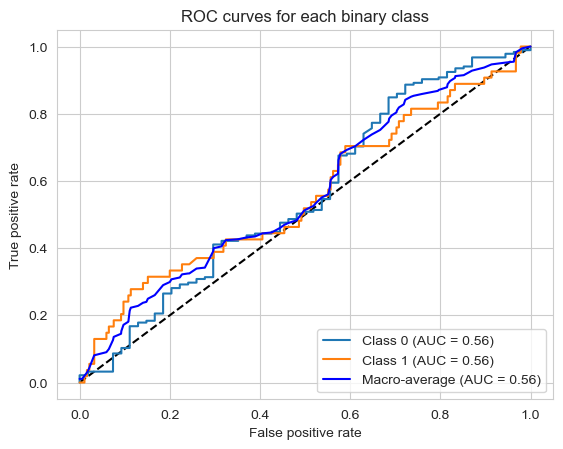

In [55]:
class_num = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(class_num):
    fpr[i], tpr[i], _ = roc_curve(y_test == str(i), y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(class_num)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(class_num):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= class_num
macro_auc = auc(all_fpr, mean_tpr)

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
for i in range(class_num):
    plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))
plt.plot(all_fpr, mean_tpr, 'b-', label='Macro-average (AUC = {:.2f})'.format(macro_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves for each binary class')
plt.legend(loc='lower right')
plt.show()

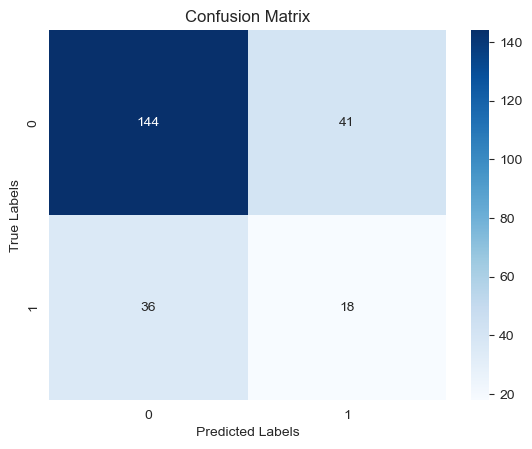

In [56]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [57]:
correlations = X_test.apply(lambda x: x.corr(y_test, method='spearman')).to_frame().set_index(X.columns)
correlations = correlations.sort_values(by=0, ascending=False)

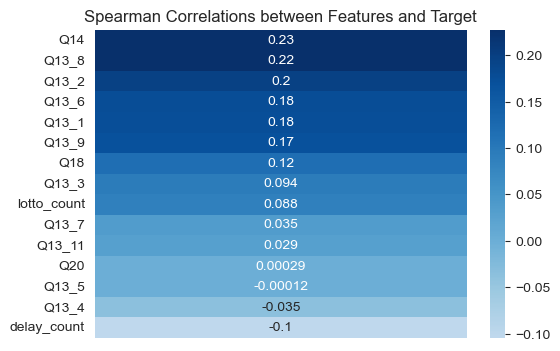

In [58]:
plt.figure(figsize=(6, 4))
sns.heatmap(correlations, annot=True, cmap='Blues', center=0, xticklabels=False, yticklabels=True)
plt.title('Spearman Correlations between Features and Target')
plt.show()

In [59]:
from scipy.stats import pointbiserialr, pearsonr
from phik import phik_from_array

In [60]:
target_variable = 'pgsi_binary'
continuous_features = numeric_cols
one_hot_encoded_features = [i for i in dummy_cols + binary_cols if i != target_variable]

In [61]:
def compute_correlation(feature_name, target_name, data, method):
    if method == 'pointbiserial':
        return pointbiserialr(data[target_name].astype('int'), data[feature_name])
    elif method == 'pearson':
        return pearsonr(data[target_name].astype('int'), data[feature_name])
    elif method == 'phi':
        # https://phik.readthedocs.io/en/latest/index.html
        return phik_from_array(data[target_name].astype('int'), data[feature_name])

In [62]:
results = []

for feature in continuous_features:
    correlation, p_value = compute_correlation(feature, target_variable, df, method='pointbiserial')
    results.append({'Feature': feature, 'Correlation': correlation, 'P-value': p_value, 'Type': 'Continuous'})

for feature in one_hot_encoded_features:
    correlation = compute_correlation(feature, target_variable, df, method='phi')
    p_value = -99
    results.append({'Feature': feature, 'Correlation': correlation, 'P-value': p_value, 'Type': 'One-Hot Encoded'})

correlation_df = pd.DataFrame(results).set_index('Feature')

In [63]:
correlations = correlation_df[['Correlation', 'P-value']].sort_values(by='Correlation', ascending=False)

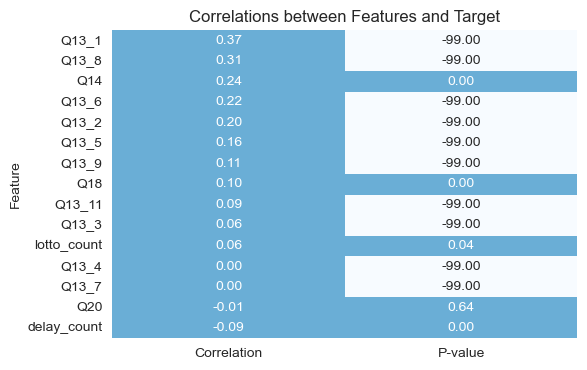

In [64]:
plt.figure(figsize=(6, 4))
sns.heatmap(correlations, annot=True, cmap='Blues', center=0, xticklabels=True, yticklabels=True, fmt='.2f', cbar=False)
plt.title('Correlations between Features and Target')
plt.show()

In [65]:
min_features_to_select = 1  # Minimum number of features to consider
models = {
    'Logistic Regression': best_lr,
    'Random Forest': best_rf,
    'Support Vector': best_svc
}

feature_ranking = []

for n, m in models.items():
    m.fit(X_train, y_train)

    result = permutation_importance(m, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)
    importance = np.round(result.importances_mean, 2)
    feature_ranking.append(list(importance))

In [66]:
f_rank_df = pd.DataFrame(feature_ranking, columns=X_test.columns).T
f_rank_df = f_rank_df.rename(columns={idx: n for idx, n in enumerate(models.keys())})
f_rank_df['importance'] = f_rank_df.apply(lambda x: np.sum(np.abs(x)), axis=1)
f_rank_df = f_rank_df.sort_values(by="importance", ascending=False)

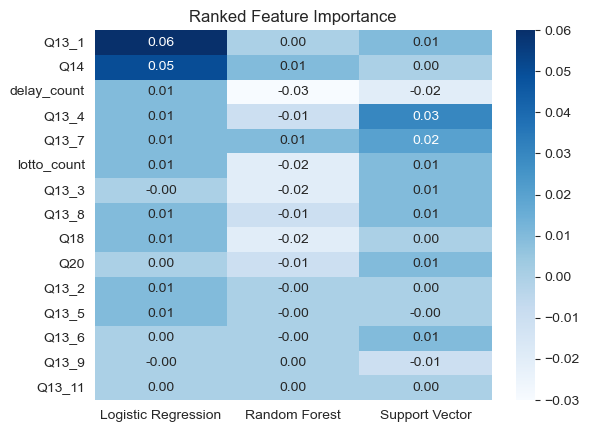

In [67]:
sns.heatmap(f_rank_df[f_rank_df.columns[:-1]], annot=True, cmap='Blues', fmt='.2f')
plt.title('Ranked Feature Importance')
plt.show()

In [68]:
# f_scores, p_values = f_classif(X_train, y_train)
f_scores, p_values = f_classif(X_test, y_test)

# Create a DataFrame to display the results
results_df = pd.DataFrame({'F-score': f_scores, 'p-value': p_values}, index=X_test.columns)
results_df = results_df.sort_values(by="F-score", ascending=False)

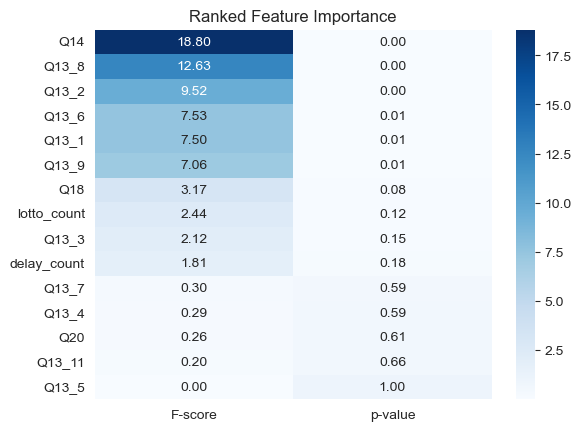

In [69]:
sns.heatmap(results_df, annot=True, cmap='Blues', fmt='.2f')
plt.title('Ranked Feature Importance')
plt.show()

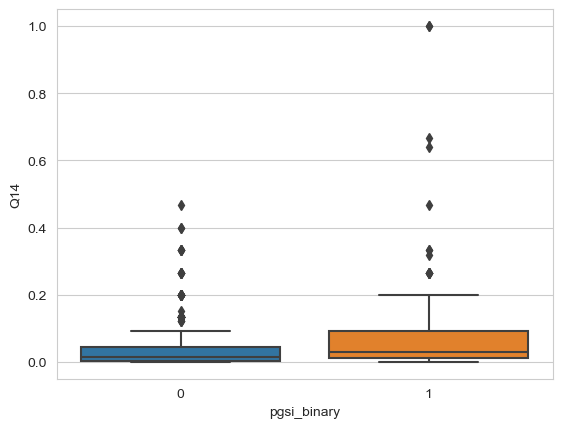

In [70]:
sns.boxplot(x='pgsi_binary', y='Q14', data=df[['pgsi_binary', 'Q14']])
plt.show()

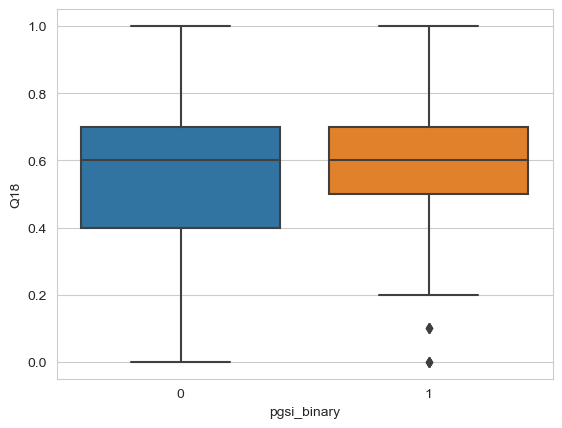

In [71]:
sns.boxplot(x='pgsi_binary', y='Q18', data=df[['pgsi_binary', 'Q18']])
plt.show()

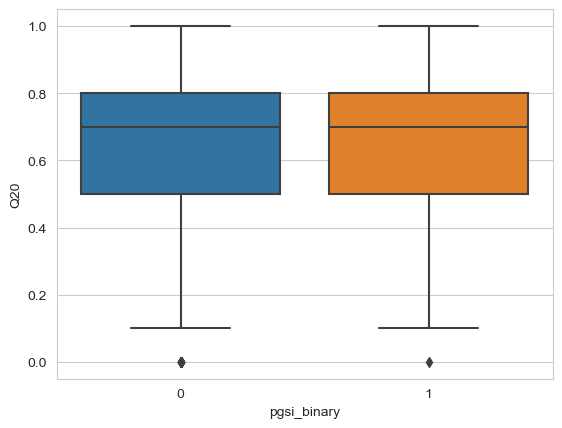

In [72]:
sns.boxplot(x='pgsi_binary', y='Q20', data=df[['pgsi_binary', 'Q20']])
plt.show()

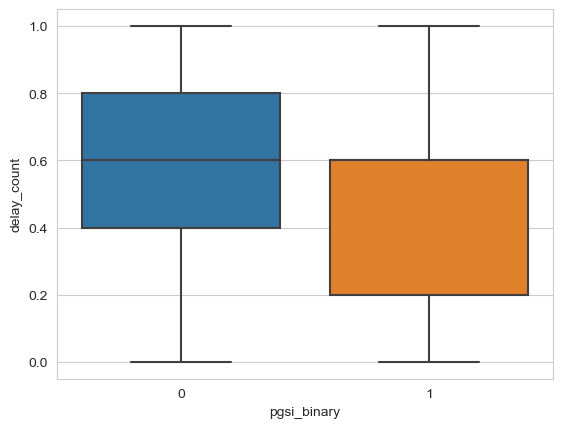

In [73]:
sns.boxplot(x='pgsi_binary', y='delay_count', data=df[['pgsi_binary', 'delay_count']])
plt.show()

In [74]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

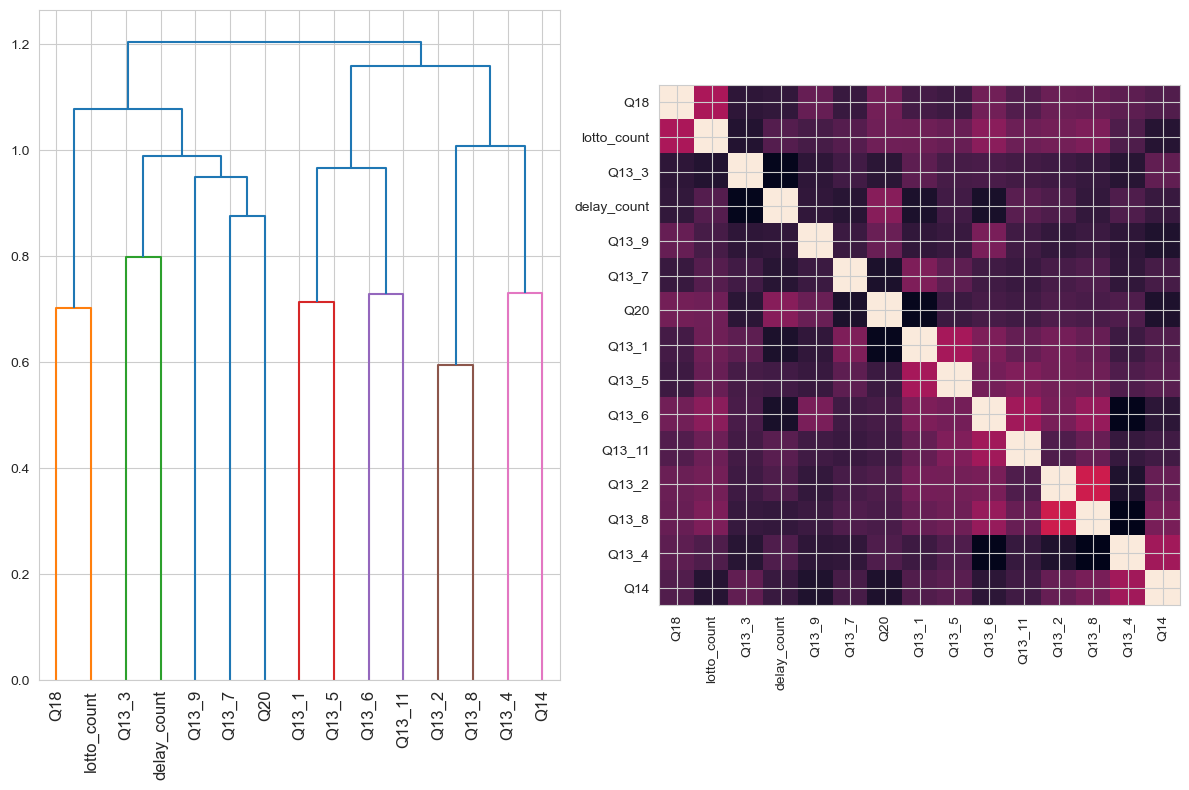

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X_test).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X_test.columns, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()